In [2]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l


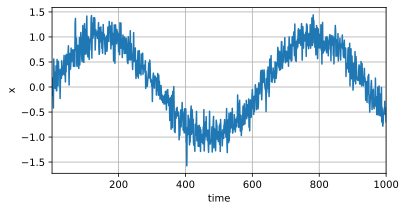

In [3]:
# 创建序列模型
T = 1000
time = torch.arange(1,T+1,dtype=torch.float32)
x = torch.sin(0.01*time)+ torch.normal(0,0.2,(T,))
d2l.plot(time,[x],"time","x",xlim=[1,1000],figsize=(6,3))

In [6]:
# 我们将这个序列转换为模型的特征－标签（feature-label）对。
# 使用马尔可夫方法
tau = 4
features = torch.zeros((T-tau,tau))
for i in range(tau):
    features[:,i] = x[i:T-tau+i]

labels = x[tau:].reshape((-1,1))
batch_size ,n_train = 16,600


In [7]:
train_iter = d2l.load_array((features[:n_train],labels[:n_train]),batch_size,is_train=True)

In [12]:
# 一个拥有两个全连接层的多层感知机，ReLU激活函数和平方损失。
def init_weights(m):
    if type(m) == nn.Linear:
        #Xavier初始化方法旨在使得网络层的输出具有相对一致的方差，
        nn.init.xavier_uniform_(m.weight)

def get_net():
    net = nn.Sequential(nn.Linear(4,8),nn.ReLU(),nn.Linear(8,1))
    net.apply(init_weights)
    return net

loss = nn.MSELoss(reduction="none")

In [13]:
def train(net,train_iter,loss,epochs,lr):
    trainer = torch.optim.Adam(net.parameters(),lr)
    for epoch in range(epochs):
        for X,y in train_iter:
            trainer.zero_grad()
            l = loss(net(X),y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
            f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')
            
net = get_net()
train(net, train_iter, loss, 5, 0.01)

<function init_weights at 0x000001731F8DA170>
epoch 1, loss: 0.063535
epoch 2, loss: 0.056834
epoch 3, loss: 0.053652
epoch 4, loss: 0.053123
epoch 5, loss: 0.050804


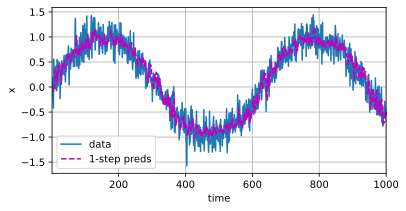

In [15]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

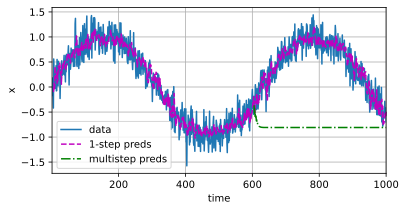

In [16]:
# 进行多步预测
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]

for i in range(n_train+tau,T):
    multistep_preds[i] = net(multistep_preds[i-tau:i].reshape(1,-1))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

如上面的例子所示，绿线的预测显然并不理想。 经过几个预测步骤之后，预测的结果很快就会衰减到一个常数。 为什么这个算法效果这么差呢？事实是由于错误的累积： 假设在步骤
之后，我们积累了一些错误

In [20]:
# 基于k=1,4,16,64，通过对整个序列预测的计算， 让我们更仔细地看一下步预测的困难。k就是用四个值往前预测的值数目

max_steps = 64
features = torch.zeros((T-tau-max_steps+1,tau+max_steps))

for i in range(tau):
    features[:,i] = x[i:i+T-tau-max_steps+1]



tensor([[-0.1694,  0.1799, -0.0184,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1799, -0.0184, -0.1430,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0184, -0.1430, -0.4199,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.2041,  0.0224,  0.1781,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0224,  0.1781,  0.1913,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1781,  0.1913,  0.3714,  ...,  0.0000,  0.0000,  0.0000]])


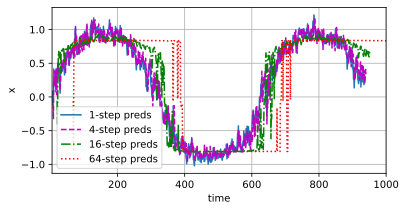

In [22]:
for i in range(tau,tau+max_steps):
    features[:,i] = net(features[:,i-tau:i]).reshape(-1)

steps = (1,4,16,64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))

In [ ]:
# 以上例子清楚地说明了当我们试图预测更远的未来时，预测的质量是如何变化的。 虽然“步预测”看起来仍然不错，但超过这个跨度的任何预测几乎都是无用的。